<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 8: Machine Learning Pipelines</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [31]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
!pip install termcolor
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
!pip install imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [32]:
df = pd.read_csv('/Users/iggyfranco/Downloads/transactions_clean_onehot.csv', nrows=100000)
to_drop = ['Unnamed: 0']
df = df.drop(to_drop, axis=1)
df['diff_datetime_hrs'] = df['diff_datetime_hrs'].fillna(0)
df.head()

,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,0.0,0.0,115.58,574089,83,66.720087,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
for col in df.columns:
    print(col)

is_fraud
diff_datetime_hrs
prev_fraud
amt
city_pop
age
dist_to_merch_in_kms
category_entertainment
category_food_dining
category_gas_transport
category_grocery_pos
category_health_fitness
category_home
category_kids_pets
category_misc_pos
category_personal_care
category_shopping_pos
category_travel
prev_category_entertainment
prev_category_food_dining
prev_category_gas_transport
prev_category_grocery_net
prev_category_grocery_pos
prev_category_health_fitness
prev_category_home
prev_category_kids_pets
prev_category_misc_net
prev_category_misc_pos
prev_category_personal_care
prev_category_shopping_net
prev_category_shopping_pos
prev_category_travel
hrs_cat_<= 1hr
hrs_cat_> 12hrs
hrs_cat_> 1hr
hrs_cat_> 24hrs
hrs_cat_> 3hrs
hrs_cat_> 6hrs
merchant_360 Fitness Club
merchant_ABS-CBN Corporation
merchant_Ace Hardware
merchant_Agila Bus Transport
merchant_AirAsia
merchant_Alfonso Liner
merchant_All Day Supermarket
merchant_Altisima Energy, Inc.
merchant_Anytime Fitness
merchant_Avon Cosmetics

Would Recommend:       0
0  89155
1    495
Proportion Chance Criterion: 98.90%
1.25 * Proportion Chance Criterion: 123.63%


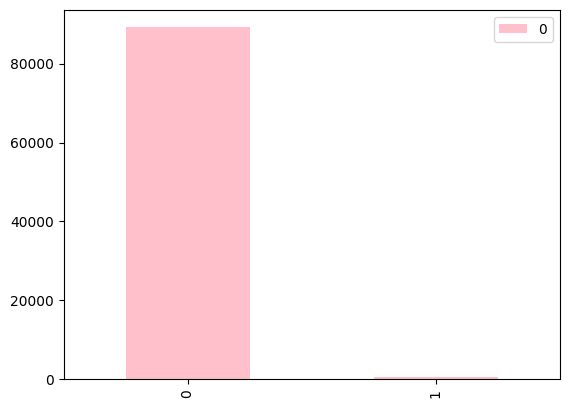

In [34]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [35]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [36]:
models_dict = {'AdaBooster': AdaBoostClassifier()}

In [37]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass
            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass
            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]


### Baseline

In [38]:
start=time.time()
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))

auto = auto_run[0]
auto_run[1]
print("Runtime (in secs):", time.time()-start)
display(auto_run[1])

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Runtime (in secs): 66.47342109680176


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
AdaBooster,12.532776,99.93%,90.70%,99.90%,86.53%


### Applying resampling techniques

#### Oversampling

In [39]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    start=time.time()
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])
    print("Runtime (in secs):", time.time()-start)


---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.9078149795532227
Resampling done in 1.0433731079101562
Resampling done in 0.8942909240722656
Resampling done in 1.2486531734466553
Resampling done in 0.9297399520874023


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
AdaBooster,61.243057,99.84%,99.80%,99.85%,95.15%


Runtime (in secs): 282.9060320854187
--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.1450049877166748
Resampling done in 0.9503879547119141
Resampling done in 1.1190531253814697
Resampling done in 0.8012599945068359
Resampling done in 0.8118488788604736


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
AdaBooster,47.458555,99.84%,99.80%,99.85%,96.77%


Runtime (in secs): 256.7600448131561


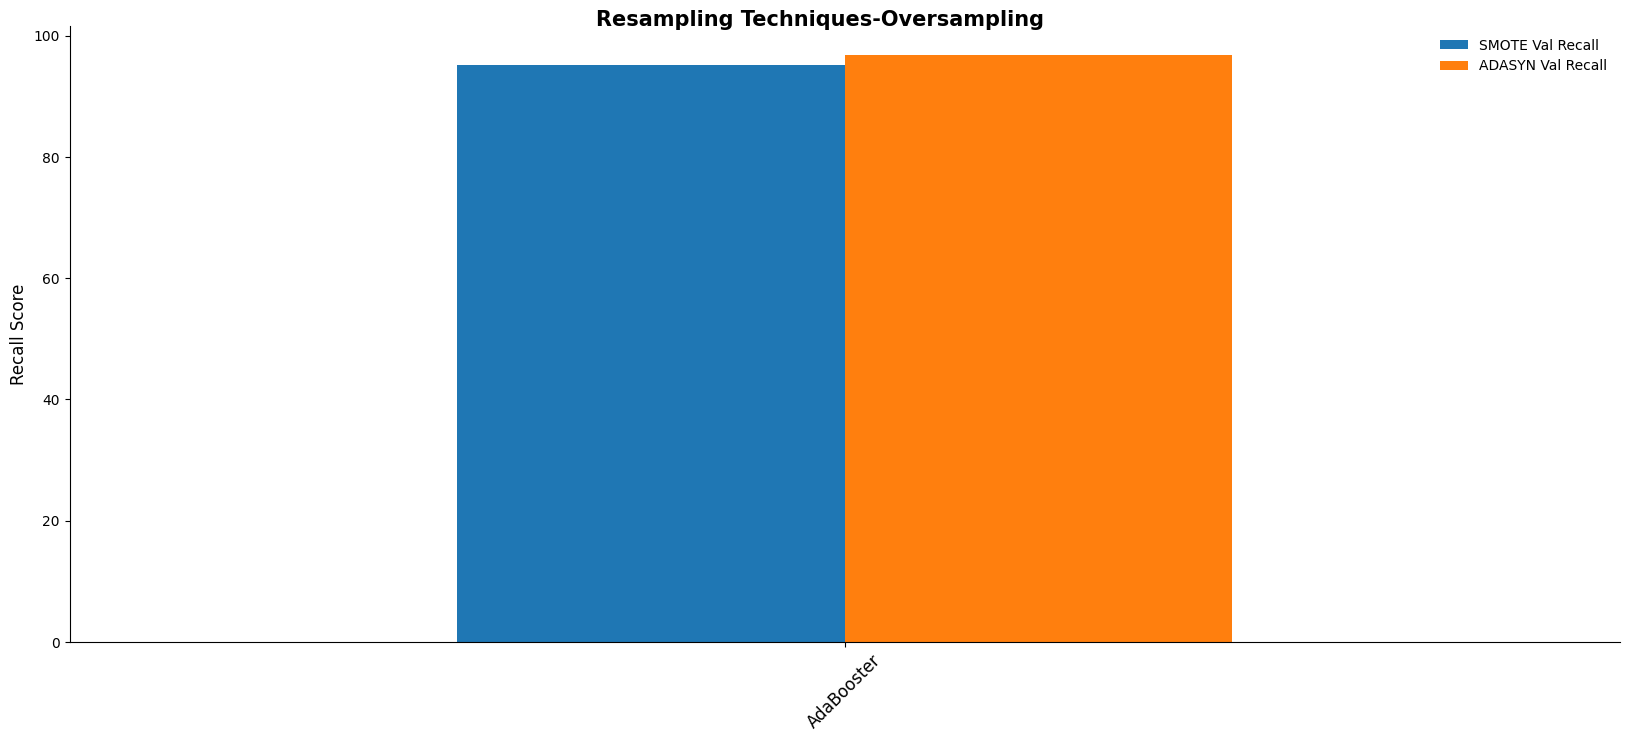

In [40]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [41]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])
    print("Runtime (in secs):", time.time()-start)

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 27.23011589050293
Resampling done in 32.852137088775635
Resampling done in 32.376314878463745
Resampling done in 32.04712796211243
Resampling done in 30.676035165786743


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
AdaBooster,21.856906,99.93%,90.29%,99.90%,85.72%


Runtime (in secs): 529.2471618652344
-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.4401881694793701
Resampling done in 0.42160677909851074
Resampling done in 0.38044309616088867
Resampling done in 0.3826911449432373
Resampling done in 0.43694210052490234


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
AdaBooster,1.335089,100.00%,100.00%,64.52%,100.00%


Runtime (in secs): 539.7683508396149


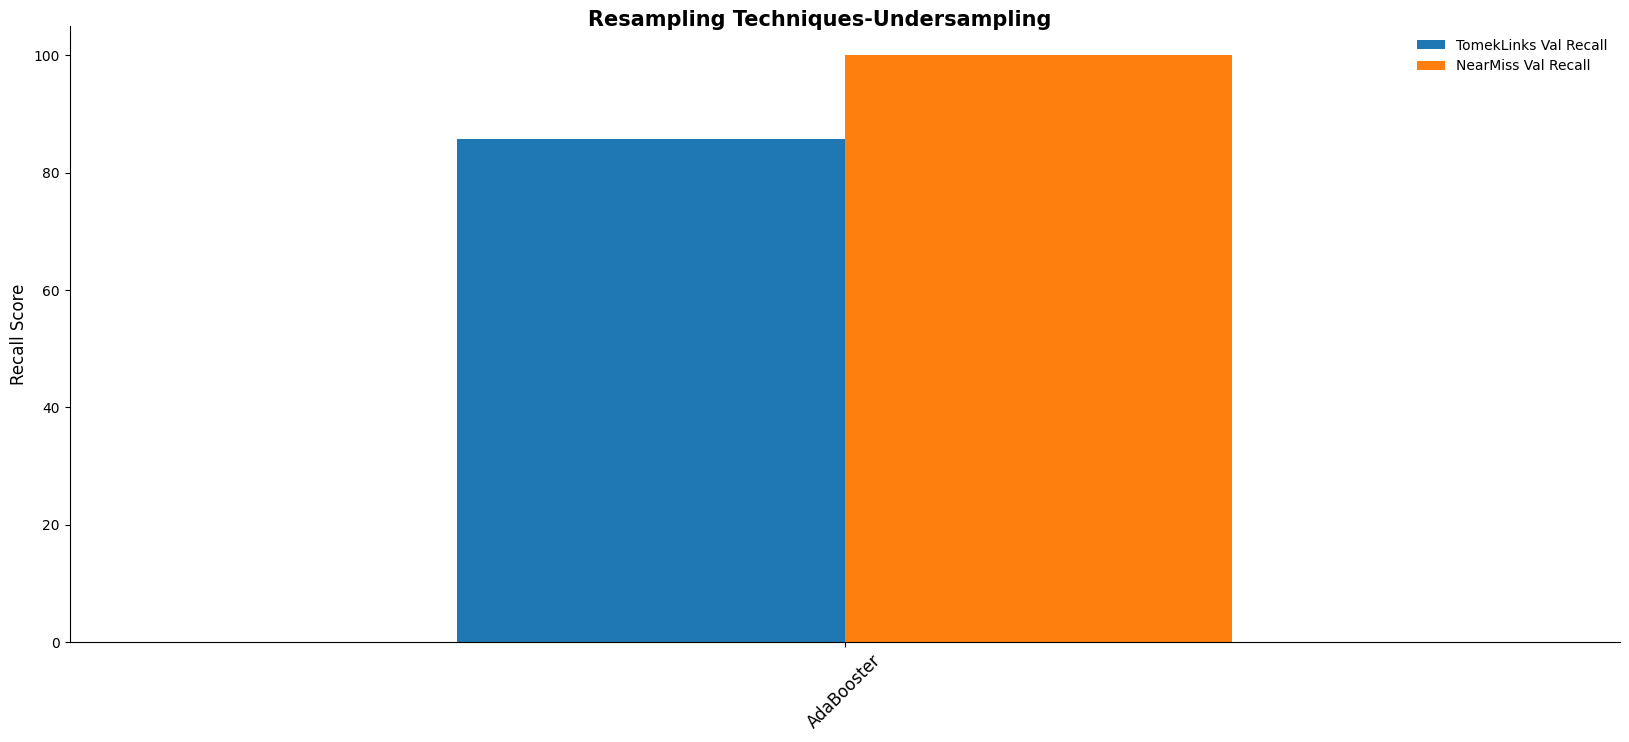

In [42]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [45]:
def train_ad(X, y, metric, res_t=None, hypertune=False, resample=False):
    """AdaBoostClassifier and apply ADASYN()"""
    params = {'n_estimators': [10, 20, 30, 40, 50]
              }
    new_params = {'adaboostclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      AdaBoostClassifier(random_state=100))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      AdaBoostClassifier(random_state=100))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['AdaBoosting', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['AdaBoostClassifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [46]:
start_time = time.time()
ad_ada_rec = train_ad(X_trainval, y_trainval, 'recall', ADASYN(),
                       hypertune=True, resample=True)
start_time = time.time()
ad_ada_acc = train_ad(X_trainval, y_trainval, 'accuracy', ADASYN(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START adaboostclassifier__n_estimators=10.........................
[CV 1/5; 1/5] END adaboostclassifier__n_estimators=10;, score=(train=0.993, test=0.986) total time=  10.6s
[CV 2/5; 1/5] START adaboostclassifier__n_estimators=10.........................
[CV 2/5; 1/5] END adaboostclassifier__n_estimators=10;, score=(train=0.986, test=0.973) total time=   9.4s
[CV 3/5; 1/5] START adaboostclassifier__n_estimators=10.........................
[CV 3/5; 1/5] END adaboostclassifier__n_estimators=10;, score=(train=0.990, test=1.000) total time=   8.6s
[CV 4/5; 1/5] START adaboostclassifier__n_estimators=10.........................
[CV 4/5; 1/5] END adaboostclassifier__n_estimators=10;, score=(train=0.993, test=0.986) total time=   8.9s
[CV 5/5; 1/5] START adaboostclassifier__n_estimators=10.........................
[CV 5/5; 1/5] END adaboostclassifier__n_estimators=10;, score=(train=0.993, test=0.986) total time=  11.0s


[CV 4/5; 4/5] END adaboostclassifier__n_estimators=40;, score=(train=0.998, test=0.998) total time=  29.9s
[CV 5/5; 4/5] START adaboostclassifier__n_estimators=40.........................
[CV 5/5; 4/5] END adaboostclassifier__n_estimators=40;, score=(train=0.999, test=0.998) total time=  30.0s
[CV 1/5; 5/5] START adaboostclassifier__n_estimators=50.........................
[CV 1/5; 5/5] END adaboostclassifier__n_estimators=50;, score=(train=0.999, test=0.998) total time=  37.1s
[CV 2/5; 5/5] START adaboostclassifier__n_estimators=50.........................
[CV 2/5; 5/5] END adaboostclassifier__n_estimators=50;, score=(train=0.999, test=0.999) total time=  37.1s
[CV 3/5; 5/5] START adaboostclassifier__n_estimators=50.........................
[CV 3/5; 5/5] END adaboostclassifier__n_estimators=50;, score=(train=0.999, test=0.999) total time=  37.2s
[CV 4/5; 5/5] START adaboostclassifier__n_estimators=50.........................
[CV 4/5; 5/5] END adaboostclassifier__n_estimators=50;, scor

In [49]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [ad_ada_rec[0],
                np.round(ad_ada_acc[1]*100, 6),
                np.round(ad_ada_acc[2]*100, 6),
                np.round(ad_ada_rec[1]*100, 6),
                np.round(ad_ada_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [ad_ada_rec[0],
                 '{:.2f}%'.format(np.round(ad_ada_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(ad_ada_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(ad_ada_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(ad_ada_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
AdaBoosting,99.82%,99.89%,98.49%,98.66%


In [75]:
# re-fitting for the holdout
rh = ad_ada_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)
rh_holdout_ascore = rh.score(X_holdout,y_holdout)

#### Feature Importance


In [80]:
rh.feature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

#### Base-case

In [76]:
# cross-validation
base_var = train_ad(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
holdout_ascore = base_model.score(X_holdout,y_holdout)

In [77]:
holdout_score

0.8709677419354839

In [78]:
holdout_ascore

0.999063043769241

In [79]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall', 'Holdout Accuracy']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_ascore*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(ad_ada_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(ad_ada_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_ascore*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall,Holdout Accuracy
No Resampling,90.70%,86.53%,87.10%,99.91%
Resampling x Hypertune,98.49%,98.66%,98.39%,99.89%


In [83]:
import pickle
# save the model to a pickle file
pickle_file_name = "ad_nestimators_sprintproj.pkl"  

with open(pickle_file_name, 'wb') as file:  
    pickle.dump(rh, file)

#### Using SHAP

In [68]:
model =  AdaBoostClassifier(random_state=11)
model = model.fit(X_trainval, y_trainval)

In [69]:
y_preds = model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Holdout set score: 0.87


In [70]:
#I have to modify SHAP directly for this.
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

In [ ]:
shap_values = explainer.shap_values(X_holdout)

In [ ]:
model.predict(X_holdout.loc[[74511]])